<a href="https://colab.research.google.com/github/kansu-lab/deep_learning_class/blob/master/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tfkl

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1.Autoencoder

In [16]:
# load the CIFAR10 dataset
data,info = tfds.load('cifar10', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteOE0DAN/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteOE0DAN/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [17]:
# data_preprocess
data_preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])

In [18]:
# get train and test 
df_train = data['train'].map(data_preprocess).map(lambda x, y: (x, x)).cache().batch(32).repeat().prefetch(5)
df_test = data['test'].map(data_preprocess)
# get image shape 
img_shape = info.features['image'].shape

In [23]:
# encoder

encoder = tfk.Sequential([
    tfkl.InputLayer(img_shape),
    tfkl.Conv2D(64,(3,3), activation=tf.nn.relu, padding="same"),
    tfkl.MaxPooling2D((2,2), padding="same"),
    tfkl.Conv2D(32,(3,3), activation=tf.nn.relu, padding="same"),
    tfkl.MaxPooling2D((2,2), padding="same"),
    tfkl.Conv2D(16, (3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.MaxPooling2D((2,2), padding="same"),])


In [24]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
Total params: 24,880
Trainable params: 24,880
Non-trainable params: 0
____________________________________________________

In [25]:
decoder = tfk.Sequential([
    tfkl.InputLayer((4, 4, 16)),
    tfkl.Conv2D(16,(3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.UpSampling2D((2, 2)),
    tfkl.Conv2D(32, (3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.UpSampling2D((2, 2)),
    tfkl.Conv2D(64, (3, 3), activation=tf.nn.relu, padding="same"),
    tfkl.UpSampling2D((2, 2)),
    tfkl.Conv2D(3, (3, 3), activation=tf.nn.relu, padding="same")
])


In [15]:
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 4, 4, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 3)        

In [18]:
input = tfkl.Input(img_shape)
h = encoder(input)
input_hat = decoder(h)

In [19]:
autoencoder = tfk.Model(inputs=input, outputs=input_hat)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 4, 4, 16)          24880     
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         27187     
Total params: 52,067
Trainable params: 52,067
Non-trainable params: 0
_________________________________________________________________


In [20]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
results = autoencoder.fit(df_train, steps_per_epoch=300, epochs=10)

Epoch 1/10
300/300 [==============================] - 63s 209ms/step - loss: 0.6620
Epoch 2/10
300/300 [==============================] - 62s 208ms/step - loss: 0.6086
Epoch 3/10
300/300 [==============================] - 62s 207ms/step - loss: 0.6081
Epoch 4/10
300/300 [==============================] - 62s 207ms/step - loss: 0.5948
Epoch 5/10
300/300 [==============================] - 62s 207ms/step - loss: 0.5947
Epoch 6/10
300/300 [==============================] - 61s 204ms/step - loss: 0.6230
Epoch 7/10
300/300 [==============================] - 61s 202ms/step - loss: 0.6222
Epoch 8/10
300/300 [==============================] - 61s 203ms/step - loss: 0.6003
Epoch 9/10
300/300 [==============================] - 61s 204ms/step - loss: 0.5967
Epoch 10/10
300/300 [==============================] - 61s 203ms/step - loss: 0.5940


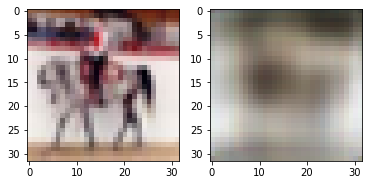

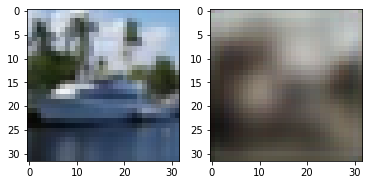

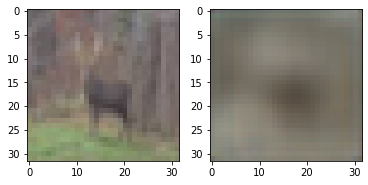

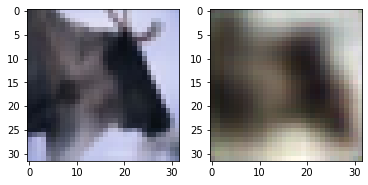

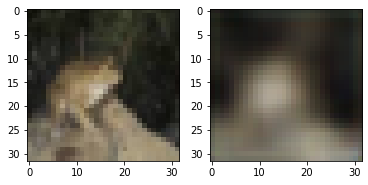

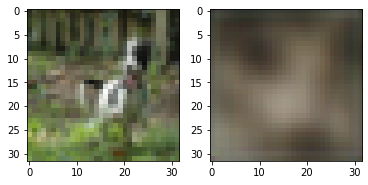

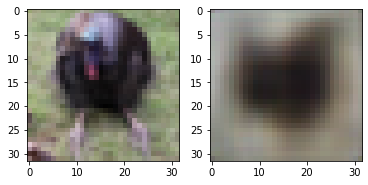

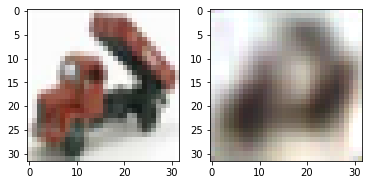

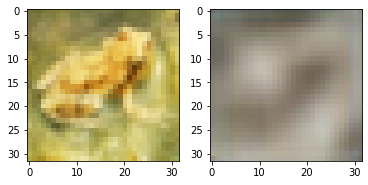

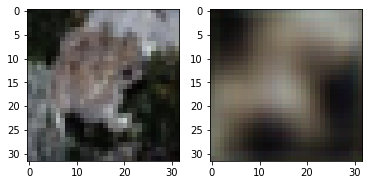

In [21]:
n = 10 
imgs = next(iter(df_train))[0]
for i in range(n):
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
    plt.subplot(1, 2, 2, )
    plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
    plt.show()

# 2. Image Classification
## 2.1 Deep CNN

In [26]:
data_preprocess2  = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

In [27]:
ds_train2 = data['train'].map(data_preprocess2).cache().batch(4)
ds_test2 = data["test"].map(data_preprocess2).cache().batch(4)

# A brief description:
## 1. depth: Including the maxpooling layers and the input layer, the model has 11 layers. 
## 2. kernel size: in each convolution layer, the kernel size is 2 by 2.
## 3. padding: All padding has set to be valid.
## 4. stride: in each convolution layer, the stride is 1.

In [28]:
# model
model = tfk.Sequential([
    tfkl.InputLayer(img_shape),
    tfkl.Conv2D(filters = 16, kernel_size= 2, strides= 1, padding= "valid",
                           activation = 'relu'),
    tfkl.MaxPooling2D((2, 2)),
    tfkl.Conv2D(filters = 32, kernel_size= 2, strides= 1, padding= "valid", activation= 'relu'),
    tfkl.MaxPooling2D((2, 2)),
    tfkl.Conv2D(filters = 64, kernel_size= 2, strides= 1, padding= "valid", activation= 'relu'),
    tfkl.MaxPooling2D((2, 2)),
    tfkl.Conv2D(filters = 128, kernel_size= 2, strides= 1, padding= "valid", activation= 'relu'),
    tfkl.Flatten(),
    tfkl.Dense(128, activation= 'relu'),
    tfkl.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 31, 16)        208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 64)          8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 128)        

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [29]:
history = model.fit(ds_train2, epochs=10, validation_data=(ds_test2))

Epoch 1/10
12500/12500 [==============================] - 87s 7ms/step - loss: 0.2241 - accuracy: 0.4667 - val_loss: 0.1892 - val_accuracy: 0.5694
Epoch 2/10
12500/12500 [==============================] - 81s 6ms/step - loss: 0.1817 - accuracy: 0.5917 - val_loss: 0.1708 - val_accuracy: 0.6201
Epoch 3/10
12500/12500 [==============================] - 83s 7ms/step - loss: 0.1651 - accuracy: 0.6327 - val_loss: 0.1661 - val_accuracy: 0.6403
Epoch 4/10
12500/12500 [==============================] - 85s 7ms/step - loss: 0.1541 - accuracy: 0.6597 - val_loss: 0.1716 - val_accuracy: 0.6341
Epoch 5/10
12500/12500 [==============================] - 84s 7ms/step - loss: 0.1461 - accuracy: 0.6808 - val_loss: 0.1703 - val_accuracy: 0.6491
Epoch 6/10
12500/12500 [==============================] - 87s 7ms/step - loss: 0.1399 - accuracy: 0.6956 - val_loss: 0.1752 - val_accuracy: 0.6484
Epoch 7/10
12500/12500 [==============================] - 85s 7ms/step - loss: 0.1340 - accuracy: 0.7093 - val_loss: 0

In [31]:
# test accuracy 
test_loss, test_acc = model.evaluate(ds_test2)
print('Test accuracy:', test_acc)

2500/2500 [==============================] - 5s 2ms/step - loss: 0.1815 - accuracy: 0.6550
Test accuracy: 0.6549999713897705


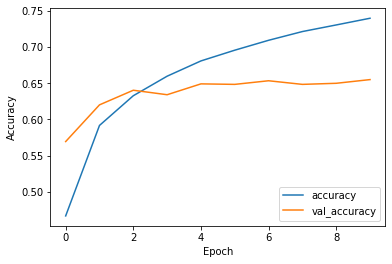

In [30]:
# evaluate the model
# model’s performance on the training set and test set.

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

##2.2 Transfer Learning

In [29]:
# get the base model 
base_model = tfk.applications.ResNet50(input_shape=(32, 32, 3),
                                include_top=False,
                                weights='imagenet')
base_model.trainable = False

In [30]:
# get features representatioin from the base model 
image2 = tfk.Input(shape=(32,32,3))
feature= base_model(image2)

In [33]:
# get a global average layer 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_average = global_average_layer(feature)
# get a predication layer 
prediction_layer = tfkl.Dense(10, activation="softmax")
outputs = prediction_layer(feature_average)

In [45]:
# the transferred model 
model_trans = tfk.Model(image2, outputs)
model_trans.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history_trans = model_trans.fit(ds_train2, epochs=9, validation_data=ds_test2)

Epoch 1/9
12500/12500 [==============================] - 518s 41ms/step - loss: 0.5768 - accuracy: 0.3904 - val_loss: 0.5598 - val_accuracy: 0.3769
Epoch 2/9
12500/12500 [==============================] - 519s 42ms/step - loss: 0.5398 - accuracy: 0.3901 - val_loss: 0.5437 - val_accuracy: 0.3776
Epoch 3/9
12500/12500 [==============================] - 518s 41ms/step - loss: 0.5279 - accuracy: 0.3903 - val_loss: 0.5375 - val_accuracy: 0.3780
Epoch 4/9
12500/12500 [==============================] - 501s 40ms/step - loss: 0.5221 - accuracy: 0.3897 - val_loss: 0.5342 - val_accuracy: 0.3774
Epoch 5/9
12500/12500 [==============================] - 523s 42ms/step - loss: 0.5188 - accuracy: 0.3895 - val_loss: 0.5320 - val_accuracy: 0.3792
Epoch 6/9
12500/12500 [==============================] - 518s 41ms/step - loss: 0.5168 - accuracy: 0.3900 - val_loss: 0.5302 - val_accuracy: 0.3802
Epoch 7/9
12500/12500 [==============================] - 514s 41ms/step - loss: 0.5155 - accuracy: 0.3900 - val_

In [46]:
# test accuracy 
test_loss, test_acc = model_trans.evaluate(ds_test2)
print('Test accuracy:', test_acc)

2500/2500 [==============================] - 88s 35ms/step - loss: 0.5268 - accuracy: 0.3826
Test accuracy: 0.38260000944137573


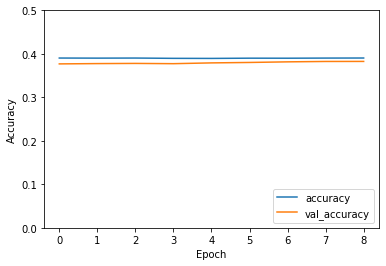

In [47]:
# evaluate the model
# model’s performance on the training set and test set.

plt.plot(history_trans.history['accuracy'], label='accuracy')
plt.plot(history_trans.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.5])
plt.legend(loc='lower right')

# 3. Text Classification
## 3.1 RNN

In [51]:
from google.colab import drive

drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [56]:
file_path = "/content/gdrive/My Drive/SPAM_detection.csv"

with open(file_path,"r") as f:
  facts = pd.read_csv(f)

In [57]:
facts.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [58]:
text = facts['Message'].str.lower()
chars = sorted(list(set(text)))

In [59]:
len(chars)

5156

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

cv = CountVectorizer(stop_words="english", max_features = 1000)
X = cv.fit_transform(text).toarray()
Y = facts["category_val"].values
X = X[:,:,None]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [61]:
model_text = tfk.Sequential()
model_text.add(tfkl.LSTM(32,input_shape = X_train.shape[1:]))
model_text.add(tfkl.Dense(8, activation="relu"))
model_text.add(tfkl.Dense(1, activation="sigmoid"))


In [62]:
model_text.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


In [63]:
model_text.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [64]:
model_text.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
140/140 [==============================] - 45s 323ms/step - loss: 0.4314 - accuracy: 0.8658 - val_loss: 0.3941 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 46s 328ms/step - loss: 0.3956 - accuracy: 0.8658 - val_loss: 0.3947 - val_accuracy: 0.8664
Epoch 3/10
140/140 [==============================] - 46s 327ms/step - loss: 0.3948 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 4/10
140/140 [==============================] - 46s 327ms/step - loss: 0.3948 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 5/10
140/140 [==============================] - 45s 325ms/step - loss: 0.3953 - accuracy: 0.8658 - val_loss: 0.3935 - val_accuracy: 0.8664
Epoch 6/10
140/140 [==============================] - 46s 328ms/step - loss: 0.3947 - accuracy: 0.8658 - val_loss: 0.3931 - val_accuracy: 0.8664
Epoch 7/10
140/140 [==============================] - 46s 328ms/step - loss: 0.3949 - accuracy: 0.8658 - val_loss: 0.3945 - val_ac

##3.2 CNN

In [66]:
model_CNN = tfk.Sequential([
    tfkl.Conv1D(filters= 32,kernel_size= 2,strides= 1,padding='valid',input_shape= (X_train.shape[1:]),
                activation= 'relu'),
    tfkl.MaxPooling1D(pool_size = 2),
    tfkl.Conv1D(filters = 64, kernel_size= 2,strides= 1,padding='valid', activation= 'relu'),
     tfkl.MaxPooling1D(pool_size = 2),
    tfkl.Conv1D(filters = 128, kernel_size= 2,strides= 1,padding='valid', activation= 'relu'), 
    tfkl.Flatten(),
    tfkl.Dense(128,activation='relu'),
    tfkl.Dense(1,activation='sigmoid')                     
])

In [67]:
model_CNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 999, 32)           96        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 499, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 498, 64)           4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 248, 128)          16512     
_________________________________________________________________
flatten_2 (Flatten)          (None, 31744)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [68]:
model_CNN.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [69]:
model_CNN.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
140/140 [==============================] - 13s 95ms/step - loss: 0.1303 - accuracy: 0.9580 - val_loss: 0.1780 - val_accuracy: 0.9489
Epoch 2/10
140/140 [==============================] - 13s 93ms/step - loss: 0.0572 - accuracy: 0.9829 - val_loss: 0.0661 - val_accuracy: 0.9830
Epoch 3/10
140/140 [==============================] - 15s 107ms/step - loss: 0.0347 - accuracy: 0.9901 - val_loss: 0.0783 - val_accuracy: 0.9848
Epoch 4/10
140/140 [==============================] - 13s 93ms/step - loss: 0.0253 - accuracy: 0.9910 - val_loss: 0.0824 - val_accuracy: 0.9830
Epoch 5/10
140/140 [==============================] - 13s 93ms/step - loss: 0.0174 - accuracy: 0.9953 - val_loss: 0.0816 - val_accuracy: 0.9821
Epoch 6/10
140/140 [==============================] - 13s 93ms/step - loss: 0.0196 - accuracy: 0.9951 - val_loss: 0.0944 - val_accuracy: 0.9874
Epoch 7/10
140/140 [==============================] - 13s 93ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.0969 - val_accuracy

## 3.3 comparison 

In [70]:
from sklearn.metrics import roc_curve, auc
rnn_test = model_text.predict(X_test)[:,0]
cnn_test = model_CNN.predict(X_test)[:,0]
target = y_test[:]>0

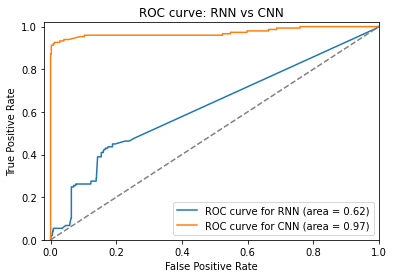

In [71]:
fpr_rnn, tpr_rnn, _ = roc_curve(target, rnn_test)
fpr_cnn, tpr_cnn ,_ = roc_curve(target, cnn_test)

plt.plot(fpr_rnn, tpr_rnn, label='ROC curve for RNN (area = %0.2f)' % auc(fpr_rnn,tpr_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='ROC curve for CNN (area = %0.2f)' % auc(fpr_cnn,tpr_cnn))
plt.plot([0, 1], [0, 1], color='gray',linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: RNN vs CNN')
plt.legend(loc="lower right")
plt.show()